--------------------
# <center>--- MDI 720 - TP2 ---</center>
--------------------
*Thomas KOCH*



Nous travaillons sur la base de données `diabetes` de python. La base initiale comporte
$n = 442$ patients et $p = 10$ covariables. La variable $Y$ à expliquer est un score correspondant à
l’évolution de la maladie. Pour s’amuser, un robot malicieux a contaminé le jeu de données en
y ajoutant 200 variables explicatives inappropriées. Ensuite, non-content d’avoir déjà perverti
notre jeu de données, il a volontairement mélangé les variables entre elle de façon aléatoire. Bien
entendu le robot a ensuite pris soin d’effacer toute trace de son acte crapuleux si bien que nous
ne connaissons pas les variables pertinentes. La nouvelle base de données comporte $n = 442$
patients et $p = 210$ covariables, notés $X$. Saurez-vous déjouer les plans de ce robot farceur et
retrouver les variables pertinentes ?



In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import math

import matplotlib.pyplot as plt  
from matplotlib import rc
from matplotlib.patches import Polygon, Circle
import matplotlib.pyplot as plt

from sklearn import linear_model, preprocessing, tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV, Ridge, RidgeCV, ElasticNetCV, Lasso, lasso_path, enet_path
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV


from mpl_toolkits.mplot3d import Axes3D

from os import mkdir, path
from functools import partial  # functions that act on or return other function

from random import randint
import warnings

import scipy.stats as stat
from scipy.stats import norm
from scipy import stats

from collections import defaultdict

%matplotlib notebook

np.random.seed(seed=10)

warnings.filterwarnings('ignore')

-----------------
### Question 1 : 
>Importer la base de données data_dm3.csv disponible depuis le lien https://bitbucket.org/portierf/shared_files/downloads/data_dm3.csv. La dernière colonne est la variable à expliquer. Les autres colonnes sont les variables explicatives. Préciser le nombre de variables explicatives et le nombre d’observations.

In [2]:
# Import des données
dfDiab = pd.read_csv('data_dm3.csv',header=None)
dfDiab.head()

,0,1,2,3,4,5,6,7,8,9,...,201,202,203,204,205,206,207,208,209,210
0,-1.298173,-0.162249,1.223379,1.355554,1.080171,0.634979,0.298741,0.548270,0.731773,1.018645,...,0.588278,0.210106,1.861458,-0.436399,0.279299,-1.416020,-2.332363,0.215096,-0.693319,151.0
1,0.166951,-0.338060,-0.618867,0.759366,1.134281,-0.536844,-0.075120,0.970251,-0.327487,0.717310,...,-0.251054,-0.825716,0.339139,1.119430,0.225958,-0.822288,0.382838,-0.718829,-0.188993,75.0
2,-0.416177,-0.205659,-1.282226,1.675500,1.523746,0.192029,-0.235840,-1.954626,-0.853309,0.892791,...,1.283837,0.372516,-0.652557,-2.579347,0.139267,-1.901196,0.048210,0.220205,0.471588,141.0
3,0.867184,-0.398667,0.093501,0.025971,1.852099,0.789774,0.801775,0.376711,0.853689,0.247953,...,0.446582,0.334733,0.399074,-0.884172,0.723819,1.316367,0.088218,0.619496,1.061662,206.0
4,1.193282,-0.936980,-0.725039,0.766078,0.223489,-1.584622,1.146866,0.086136,-0.088780,-0.945066,...,0.786157,-1.058179,-0.155788,-0.642504,2.040010,-1.703110,-1.901502,1.778811,-0.489853,135.0


In [3]:
type(dfDiab)

pandas.core.frame.DataFrame

In [4]:
dfDiab.shape

(442, 211)

In [5]:
# Observation et variable à expliquer
y_to_explain = dfDiab.iloc[:,-1]

print('Le nombre de variables explicatives est de {} .'.format(len(dfDiab.iloc[1,:])-1))
print('Le nombre d\'observations est de {} .'.format(len(y_to_explain)))

Le nombre de variables explicatives est de 210 .
Le nombre d'observations est de 442 .


-----------------
### Question 2 : 
>Les variables explicatives sont-elles centrées ? Normalisées ? Qu’en est-il de la variable à
expliquer ? Tracer un scatter plot de la base de données avec 4 covariables prises au hasard
et la variable à expliquer (un scatterplot regroupe les graphes de chacune des variables en
fonction de chacune des autres). Commenter les graphiques obtenus.

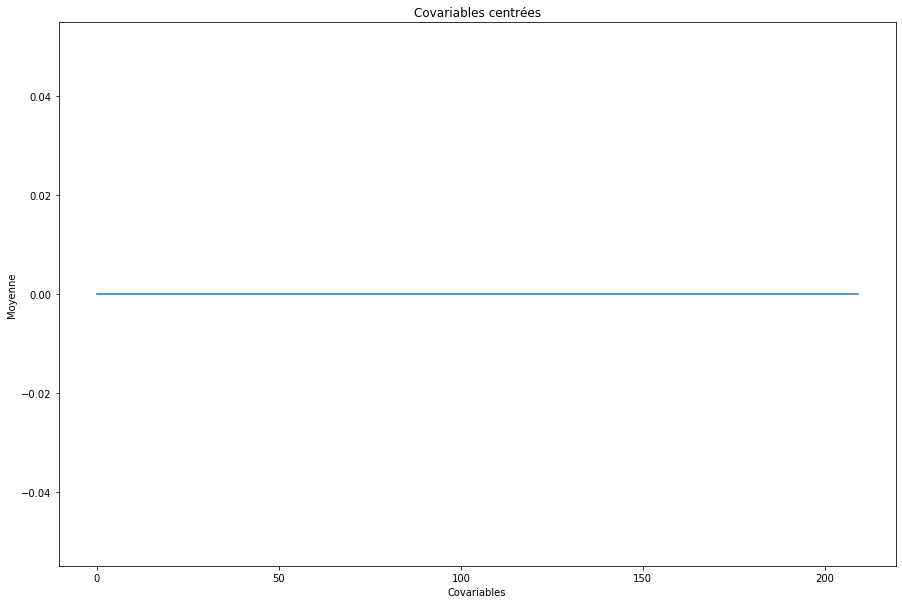

In [6]:
plt.figure(figsize=(15,10))
plt.plot(round(np.mean(dfDiab.iloc[:,0:-1])))
plt.xlabel("Covariables")
plt.ylabel("Moyenne")
plt.title("Covariables centrées")
plt.show()

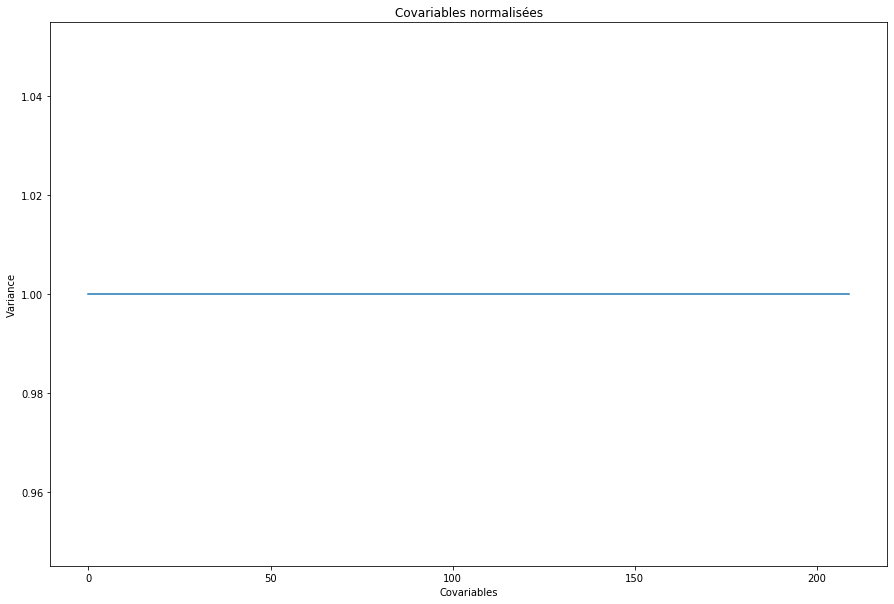

In [7]:
plt.figure(figsize=(15,10))
plt.plot(round(np.var(dfDiab.iloc[:,0:-1])))
plt.xlabel("Covariables")
plt.ylabel("Variance")
plt.title("Covariables normalisées")
plt.show();

On constate donc que les covariables sont centrées et normalisées puisque leurs espérance sont égales à 0, et que leurs variances vaut 1.

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

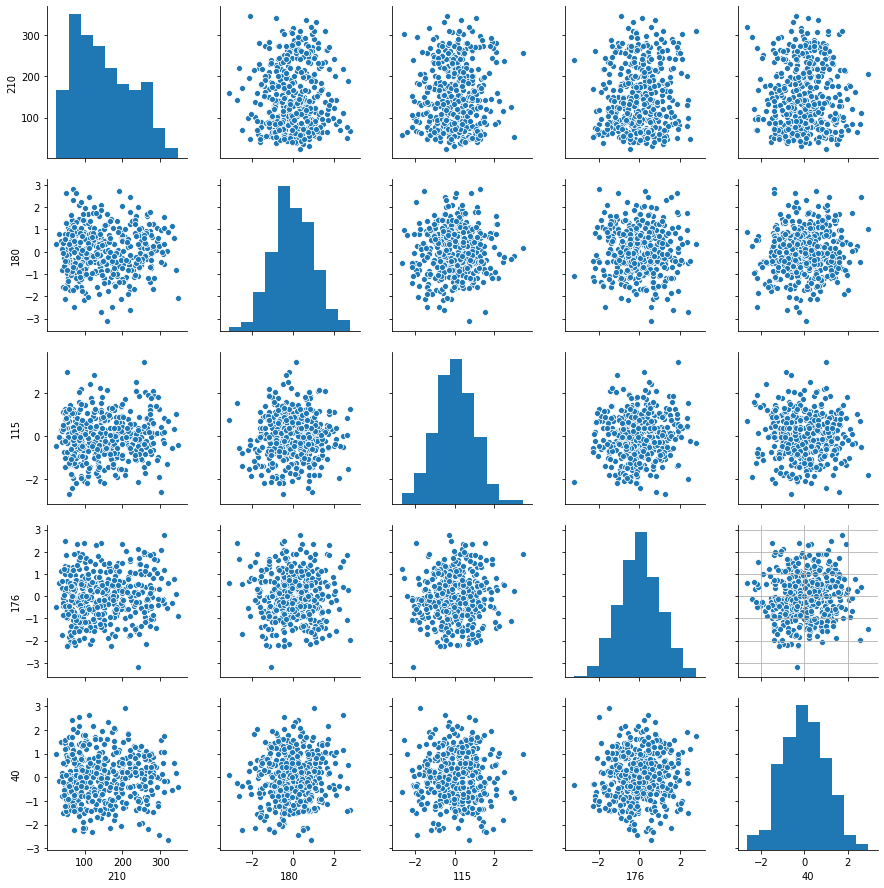

In [8]:
num_rand=[]
plt.clf()
plt.figure()

for i in range(4):
    num_rand.append(randint(0,len(dfDiab.iloc[1,:])-1))    

dfDiab1 = dfDiab.iloc[:,0:-1]
X_explanatory = dfDiab1.iloc[:,num_rand]
#pd.plotting.scatter_matrix(X_explanatory)

Y_X = pd.concat([y_to_explain,X_explanatory], axis=1)
sns.pairplot(Y_X)
plt.grid(True)
plt.show();

In [9]:
for i in range(0,4):    
    print("La covariable {} a une espérance de {:.4f} et une variance de {:.4f}".format(X_explanatory.columns[i],np.mean(X_explanatory.iloc[:,i]),np.var(X_explanatory.iloc[:,i])))

print("La variable à expliquer a pour espérance {:.2f} et pour variance {:.2f}".format(np.mean(y_to_explain),np.var(y_to_explain)))

La covariable 180 a une espérance de -0.0000 et une variance de 1.0000
La covariable 115 a une espérance de -0.0000 et une variance de 1.0000
La covariable 176 a une espérance de -0.0000 et une variance de 1.0000
La covariable 40 a une espérance de 0.0000 et une variance de 1.0000
La variable à expliquer a pour espérance 152.13 et pour variance 5929.88


On retrouve donc que les covariables sont centrées et normalisées puisque leurs espérance sont égales à 0, et que leurs variances vaut 1.

En revanche, la variable à expliquer n'est ni centrée, ni normalisée.

------------
### Question 3 :
>Echantillon d’apprentissage et de test. Créer 2 échantillons : un pour apprendre le modèle
$X_{train}$, un pour tester le modèle $X_{test}$. On mettra 20\% de la base dans l’échantillon "test". Donner les tailles de chacun des 2 échantillons. On notera que le nouvel échantillon de
covariables $X_{train}$ n’est pas normalisé. Dans la suite, on fera donc bien attention à inclure
l’intercept dans nos régression.

In [10]:
X_explanatory = dfDiab1 #on prend cette fois toutes les covariables dans X

X_train, X_test, y_train, y_test = train_test_split(X_explanatory, y_to_explain, test_size = 0.2)
print("La taille de l'échantillon d'entrainement est de {:.0f} patients.".format(len(X_train)))
print("La taille de l'échantillon de test est de {:.0f} patients.".format(len(X_test)))

La taille de l'échantillon d'entrainement est de 353 patients.
La taille de l'échantillon de test est de 89 patients.


------------
### Question 4 :

>Donner la matrice de covariance calculée sur $X_{train}$. Tracer le graphe de la décroissance des
valeurs propres de la matrice de covariance (ou de corrélation). Expliquer pourquoi il est
légitime de ne garder que les premières variables de l’ACP. On gardera 60 variables dans
la suite.

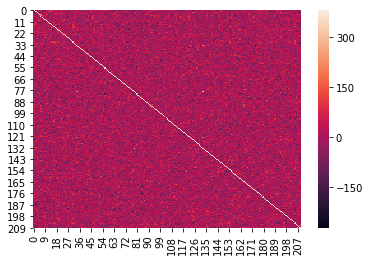

In [11]:
# Matrice de covariance

# On recentre nos données
X_train_center = X_train - np.mean(X_train)
y_train_center = y_train - np.mean(y_train)

X_test_center = X_test - np.mean(X_test)
y_test_center = y_test - np.mean(y_test)

# sns.heatmap(np.cov(X_train)) 
cov = np.dot(np.transpose(X_train_center),X_train_center)
sns.heatmap(cov)
plt.show()

In [12]:
cov.shape

(210, 210)

In [13]:
#X_train_cov = np.cov(X_train.T)
#X_train_cov.shape
#sns.heatmap(X_train_cov)

In [14]:
# Calcul de la matrice de corrélation
corr = X_train_center.corr()

#Calcul des valeurs propres et vecteurs propres
eigenvalues = np.linalg.eigh(corr)
eigenvectors = np.linalg.eigh(corr)[1]

<Figure size 432x288 with 0 Axes>

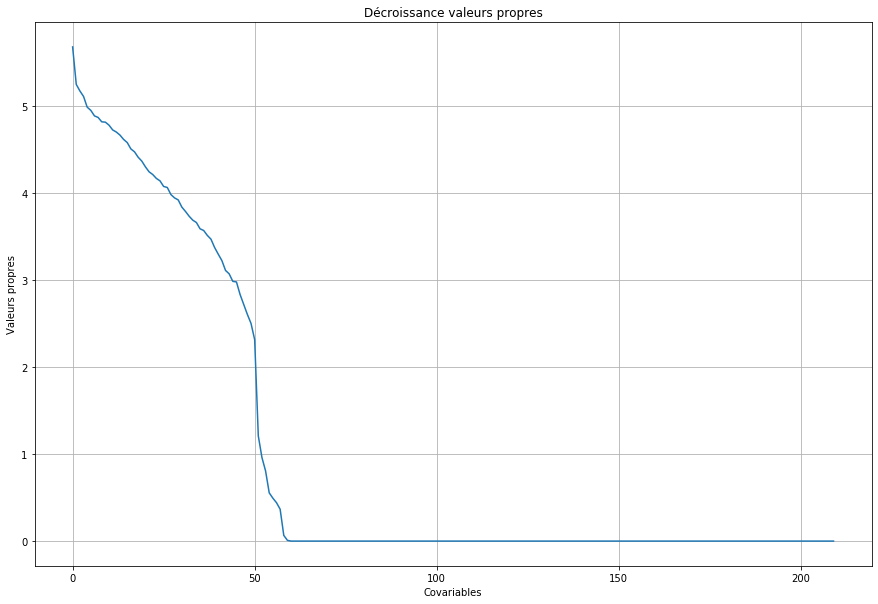

In [16]:
#Graphe de la décroissance des valeurs propres
plt.clf()
plt.figure(figsize=(15,10))
plt.plot(sorted(eigenvalues[0],reverse=True))
plt.xlabel("Covariables")
plt.ylabel("Valeurs propres")
plt.title("Décroissance valeurs propres")
plt.grid(True)
plt.show()

Il est légitime de ne garder que les 60 premières variables de l'ACP car on constate avec le graphe ci-dessus que les autres variables ont des valeurs propres nulles, c'est-à-dire qu'elles sont le résultat d'une combinaison linéaire de ces 60 variables.

----------------------
### Question 5 :
>Suivant les observations de la question (Q4), appliquer la méthode de "PCA before OLS"
qui consiste à appliquer OLS avec $Y$ et $X_{train}V_{(1:60)}$, où $V_{(1:60)}$ contient les vecteurs propres (associés aux 60 plus grandes valeurs propres) de la matrice de covariance. Faire une régression linéaire (avec intercept), puis tracer les valeurs des coefficients (hors intercept).
Sur un autre graphique, faire de même avec la méthode des moindres carrés classique.

<Figure size 432x288 with 0 Axes>

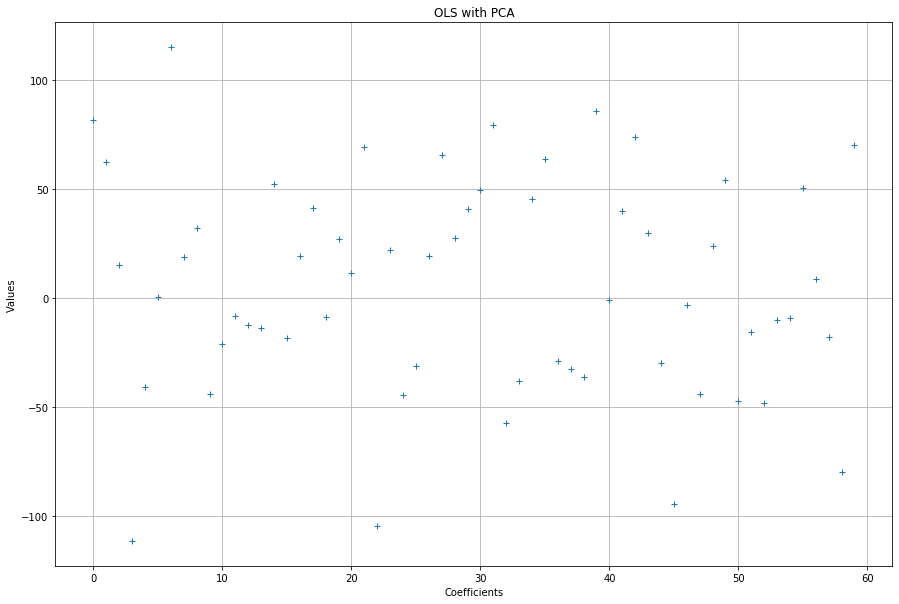

In [17]:
# PCA before OLS
# Nous n'utilisons plus les données centrées

X_pca = np.dot(X_train,np.transpose(eigenvectors[150:]))
linear_reg_pca = linear_model.LinearRegression()
linear_reg_pca.fit(X_pca , y_train)

plt.clf()
plt.figure(figsize=(15,10))
plt.plot(linear_reg_pca.coef_,'+')
plt.xlabel("Coefficients")
plt.ylabel("Values")
plt.title("OLS with PCA")
plt.grid(True)
plt.show()

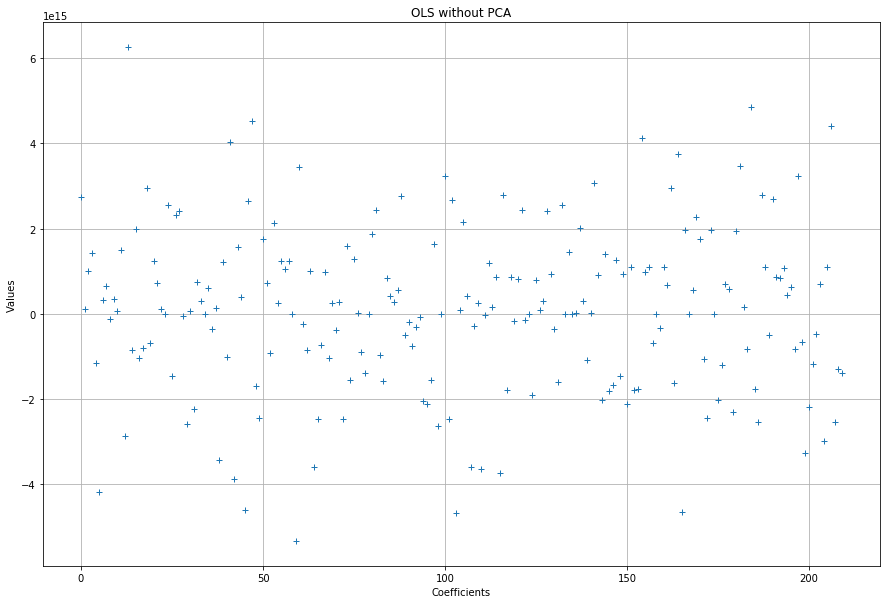

In [18]:
# OLS without PCA
X_no_pca = X_train
linear_reg_no_pca = linear_model.LinearRegression()
linear_reg_no_pca.fit(X_no_pca, y_train)

plt.figure(figsize=(15,10))
plt.plot(linear_reg_no_pca.coef_,'+')
plt.xlabel("Coefficients")
plt.ylabel("Values")
plt.title("OLS without PCA")
plt.grid(True)
plt.show()

--------------
### Question 6 :

>Donner les valeurs des intercepts pour les 2 régressions précédentes. Donner la valeur
moyenne de la variable $Y$ (sur le train set). Les intercepts des 2 questions sont-ils égaux ?
Commenter. Uniquement pour cette question, centrer et réduire les variables après ACP
(de petite dimension). Faire une régression avec ces variables et vérifier que l’intercept est
bien égal à la moyenne de Y sur le train.

In [19]:
# Affichage de l'intercept pour OLS avec ACP
print("L'intercept pour l'OLS avec ACP est de {:.4f}".format(linear_reg_pca.intercept_))

# Affichage de l'intercept pour OLS sans ACP
print("L'intercept pour l'OLS sans ACP est de {:.4f}".format(linear_reg_no_pca.intercept_))

# Affichage de la moyenne de la variable y_train
print("La moyenne de la variable Y sur le dataset d'entrainement est de {:.4f}".format(y_train.mean()))

L'intercept pour l'OLS avec ACP est de 151.6108
L'intercept pour l'OLS sans ACP est de 152.4491
La moyenne de la variable Y sur le dataset d'entrainement est de 152.9178


Les données utilisées n'étant pas normalisées, il est normal que notre intercept ne soit pas exactement égal à la moyenne de la variable à expliquer.

In [20]:
# Normalisation de X_train
X_train_scaled = preprocessing.scale(X_train, with_mean='True', with_std='True')
X_pca_scaled = preprocessing.scale(X_pca, with_mean='True', with_std='True')

linear_reg1 = linear_model.LinearRegression()
linear_reg1.fit(X_train_scaled , y_train)

linear_reg2 = linear_model.LinearRegression()
linear_reg2.fit(X_pca_scaled , y_train)

# Intercept pour OLS avec ACP 
print("L'intercept pour l'OLS avec ACP et données normalisées est de {:.4f}".format(linear_reg2.intercept_))

# Moyenne de y_train
print("La moyenne de la variable y à expliquer (set d'entrainement) est de {:.4f}".format(np.mean(y_train)))

L'intercept pour l'OLS avec ACP et données normalisées est de 152.9178
La moyenne de la variable y à expliquer (set d'entrainement) est de 152.9178


-------------------------
### Question 7 :
>Pour les 2 méthodes (OLS et PCA before OLS) : 
* Tracer les résidus de la prédiction sur l’échantillon test. 
* Tracer leur densité (on pourra par exemple utiliser un histogramme).
* Calculer le coefficient de détermination sur l’échantillon test. 
* Calculer le risque de prédiction sur l’échantillon test.



-----MODELE OLS SANS ACP-----

Le risque de prédiction sur l'échantillon de test est de 4395 
Le coefficient de détermination est de R2 = 0.2969



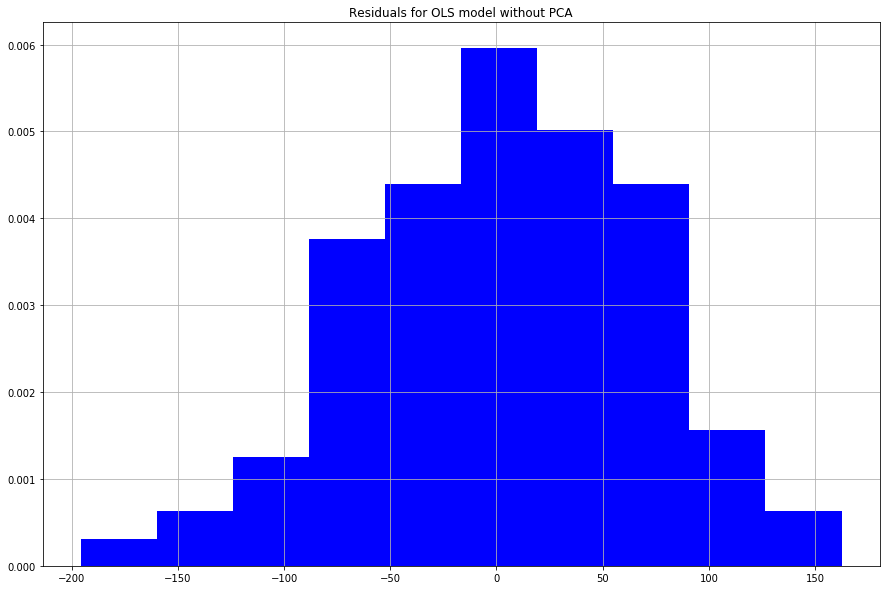

In [21]:

y_predict_no_pca = linear_reg_no_pca.predict(X_test)
residual_no_pca = y_predict_no_pca - y_test

plt.figure(figsize=(15,10))
plt.hist(residual_no_pca, density=True, color="b")
plt.title("Residuals for OLS model without PCA")
plt.grid(True)

R2_no_pca = r2_score(y_test,y_predict_no_pca)

risk_score_no_pca = mean_squared_error(y_test,y_predict_no_pca)

print("\n-----MODELE OLS SANS ACP-----\n")
print("Le risque de prédiction sur l'échantillon de test est de {:.0f} ".format(risk_score_no_pca))
print("Le coefficient de détermination est de R2 = {:.4f}\n".format(R2_no_pca))


----- MODELE OLS AVEC ACP -----

Le risque de prédiction sur l'échantillon de test est de 3002 
Le coefficient de détermination est de R2 = 0.5198



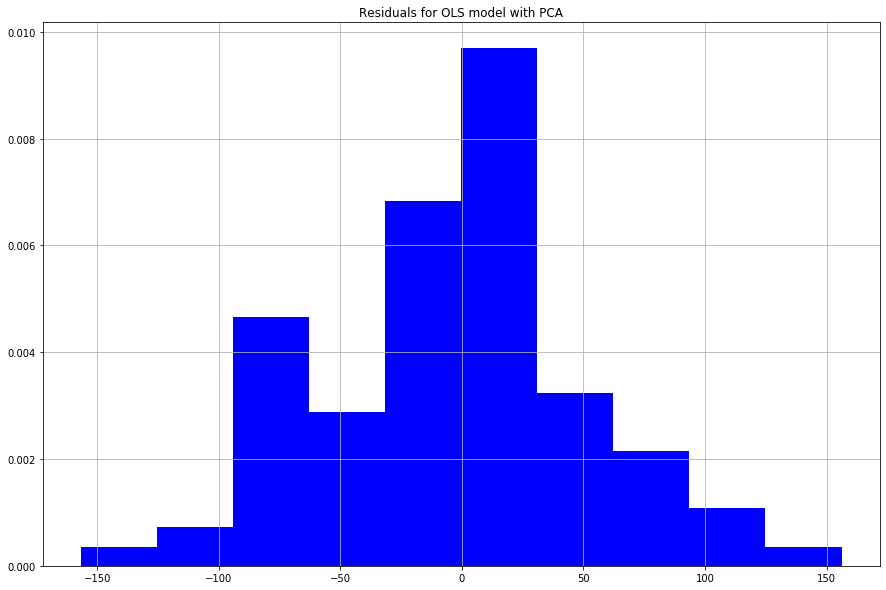

In [22]:

X_test_pca = np.dot(X_test,np.transpose(eigenvectors[150:]))
y_predict_pca = linear_reg_pca.predict(X_test_pca)
residual_pca = y_predict_pca - y_test

plt.figure(figsize=(15,10))
plt.hist(residual_pca, density=True, color="b")
plt.title("Residuals for OLS model with PCA")
plt.grid(True)

risk_score_pca = mean_squared_error(y_test,y_predict_pca)
R2_pca = r2_score(y_test,y_predict_pca)

print("\n----- MODELE OLS AVEC ACP -----\n")
print("Le risque de prédiction sur l'échantillon de test est de {:.0f} ".format(risk_score_pca))
print("Le coefficient de détermination est de R2 = {:.4f}\n".format(R2_pca))

-----------------
### Question 8 :
> Coder la méthode de forward variable sélection. On pourra utiliser la statistique du test de
nullité du coefficient (comme vu en cours). Pour l’instant, on ne met pas de critère d’arret
sur la méthode. C’est à dire que l’on ajoute une variable à chaque étape jusqu’à retrouver
la totalité des variables. Afficher l’ordre de séléction des variables.

In [23]:
# Initialisation
n = len(y_train)
p = X_train.shape[1] + 1
X_tilde = np.concatenate((np.ones((n,1)), X_train), axis=1) 
r = y_train
list_ind_var = []

# Algo de sélection des variables (uniquement)

for step in range (p):
    T = np.zeros(p)
    for k in range(p):
        if k-1 in list_ind_var:
            continue
        else:
            coef = linear_model.LinearRegression(fit_intercept=False).fit(X_tilde[:,k].reshape(n,1), r).coef_[0]
            sigma = math.sqrt(np.linalg.norm(r - coef*X_tilde[:,k]) / (n - 1)) 
            T[k] = abs(coef) / (sigma * math.sqrt(np.linalg.norm(X_tilde[:,k])))
    winner = np.argsort(-T)[0]
    list_ind_var.append(winner-1)  
    r = r - coef*X_tilde[:,winner]

df1 = pd.DataFrame(list_ind_var[1::]) #on retire l'intercept en première position
df1.columns = ['Variables sélectionnées']
print ("L'ordre de sélection des variables est le suivant : \n")
print(df1.to_string())

L'ordre de sélection des variables est le suivant : 

     Variables sélectionnées
0                         58
1                        123
2                         34
3                        174
4                        167
5                         23
6                        133
7                         79
8                         99
9                        154
10                        47
11                       208
12                        49
13                        44
14                       109
15                        30
16                        52
17                       200
18                       196
19                        55
20                       146
21                       115
22                       180
23                        25
24                       138
25                       155
26                       191
27                       135
28                       132
29                        14
30                        39
31                

Vérifions avec la méthode de `sklearn` que nous obtenons bien la même sélection de variables :

In [24]:
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest

f, p_value = f_regression(X_train, y_train, False)

df2 = pd.DataFrame(np.argsort(p_value))
df2.columns = ['Variables sélectionnées']

print("L'ordre de sélection des variables est le suivant : \n")
print(df2.to_string())
#print((df1 == df2).to_string())

L'ordre de sélection des variables est le suivant : 

     Variables sélectionnées
0                         58
1                        123
2                         34
3                        174
4                        167
5                         23
6                        133
7                         99
8                         79
9                        208
10                       154
11                       109
12                        47
13                       172
14                        52
15                        30
16                       180
17                        17
18                       155
19                        44
20                       146
21                       162
22                        25
23                       131
24                       200
25                         9
26                        45
27                       104
28                       138
29                        77
30                       145
31                

On constate donc que notre méthode semble retenir les mêmes variables. On note toutefois que le calcul est bien plus rapide avec la méthode de `sklearn`.

In [ ]:
'''
dfDiab1_X_aug = np.column_stack((np.ones((X_train.shape[0], 1 )), X_train)) 
n = dfDiab1_X_aug.shape[0]
p = dfDiab1_X_aug.shape[1]

test = np.zeros((p,p))
pval_mem = np.zeros(p)
pval = np.zeros((p,p))
resids = y_train

# Initialisation
var_sel = []
var_remain = list(range(p))
test = []

regr = linear_model.LinearRegression(fit_intercept=False)

for k in range(p): 
    resids_mem = np.zeros((p,n))
    
    for i in var_remain:
        xtmp = dfDiab1_X_aug [:,[i]]
        regr.fit(xtmp, resids)
        
        xx = np.sum(dfDiab1_X_aug [:,[i]] ** 2 )   
        resids_mem [i,:] = regr.predict(xtmp) - resids
        sigma2_tmp = np.sum(resids_mem [i,:] ** 2) / (xx)
        test[k,i] = np.sqrt(n-1) * np.abs(regr.coef_) / (np.sqrt( sigma2_tmp )) 
        pval[k,i] =   2 * (1 - norm.cdf(test[k,i]))
        
    #### Séparation en deux vecteurs de la liste des variables séléctionnées et des autres
    best_var = np.argmax(test[k,:])
    var_sel.append(best_var)
    resids = resids_mem[best_var,:]
    pval_mem [k] = pval[k,best_var]
    var_remain = np.setdiff1d(var_remain, var_sel)


var_sel1 = [x-1 for x in var_sel[1:]]
df = pd.DataFrame(var_sel1)
df.columns = ['Variables sélectionnées']
print ("L'ordre de sélection des variables est le suivant : ")
print(df.to_string())
'''

------------------------
### Question 9 :
>Critère d’arrêt : On décide d’arrêter lorsque la p-valeur dépasse 0.1. Illustrer la méthode
en donnant :
* ***(i)*** les 3 graphes des statistiques obtenues lors de la sélection de la 1er, 2eme
et 3eme variables (en abscisse : l’index des variables, en ordonné : la valeur des stats),
* ***(ii)*** le graphe des 50 premières p-valeurs (dont chacune est associée à la variable sélectionnée). Sur ce même graphe, on tracera la ligne horizontale d’ordonnée 0.1. 
* ***(iii)*** Enfin on donnera la liste des variables sélectionnées.

In [45]:
################################# ALGO COMPLET pour le critère d'arrêt défini ###############################

# Initialisation
X_tilde = np.concatenate((np.ones((n,1)), X_train), axis=1) 
r = y_train
list_ind_var = []
T = np.zeros((p,p))
p_val_mem = np.zeros(p)
step_break = 0

for step in range (p):
    for k in range(p):
        if k-1 in list_ind_var :
            continue
        else:
            coef = linear_model.LinearRegression(fit_intercept=False).fit(X_tilde[:,k].reshape(n,1), r).coef_[0]
            sigma = math.sqrt(np.linalg.norm(r - coef*X_tilde[:,k]) / (n - 1)) 
            T[step, k] = abs(coef) / (sigma * math.sqrt((n-1) / np.linalg.norm(X_tilde[:,k])))
    winner = np.argsort(-T[step,:])[0]
    p_val_mem[step] = 2*(1 - stat.t.cdf(T[step, winner],df=n-1))
    if  (p_val_mem[step] > 0.1) and (step_break == 0):
        step_break = step
    list_ind_var.append(winner-1)  
    r = r - coef*X_tilde[:,winner]

df1 = pd.DataFrame(list_ind_var[1::]) #on retire l'intercept sélectionné en première position
df1.columns = ['Variables sélectionnées']
print ("L'ordre de sélection des variables est le suivant : \n")
print(df1.to_string())

L'ordre de sélection des variables est le suivant : 

     Variables sélectionnées
0                         58
1                        123
2                         34
3                        174
4                        167
5                         23
6                        133
7                         79
8                         99
9                        154
10                       208
11                        47
12                        49
13                        44
14                       109
15                        30
16                        52
17                       200
18                       196
19                        55
20                       146
21                       115
22                       180
23                        25
24                       155
25                       138
26                       191
27                       135
28                       132
29                        14
30                        39
31                

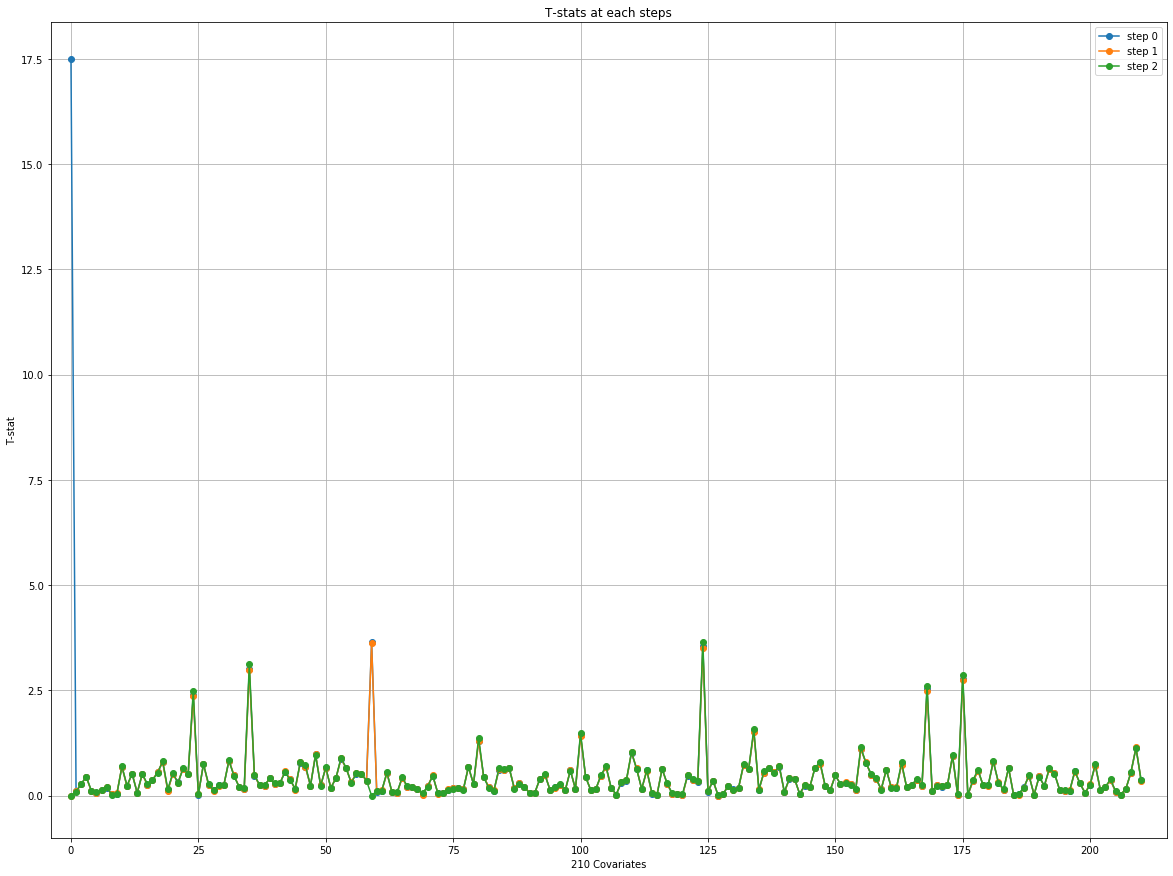

In [46]:
plt.figure(figsize=(20,15))
plt.title("T-stats at each steps")
plt.xlabel("210 Covariates")
plt.ylabel("T-stat")

for k in range(3): 
    plt.plot(T[k,:], '-o', label = "step "+str(k))

plt.axis(xmin = -4, xmax = 215, ymin = -1)
plt.legend()
plt.grid(True)
plt.show()

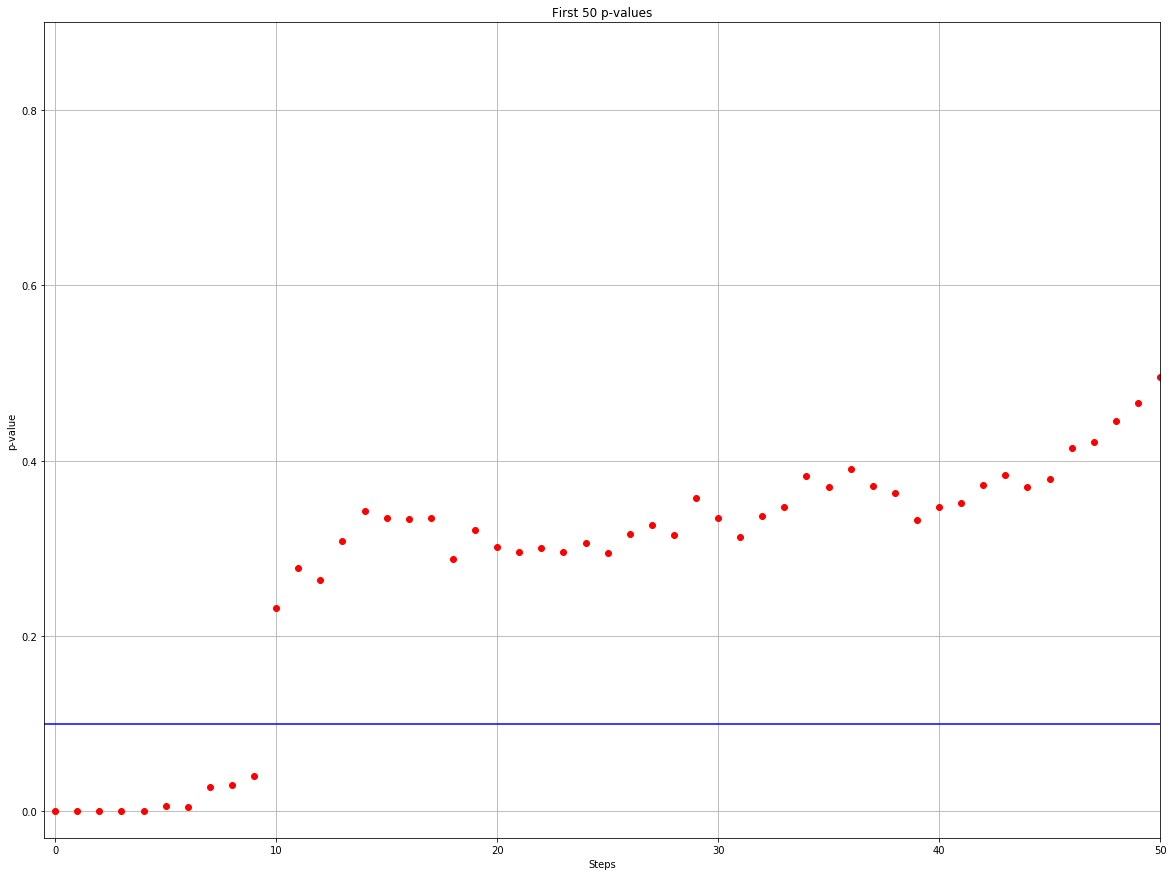

In [47]:
fig2 = plt.figure(figsize=(20,15)) 

plt.plot(p_val_mem, 'o', color = 'red')
plt.plot([-.5,50], [.1,.1], color = "blue" )
plt.axis(xmin = -.5, xmax = 50, ymin = -.03, ymax = 0.9)
plt.title("First 50 p-values")
plt.ylabel("p-value")
plt.xlabel("Steps")
plt.grid(True)
plt.show()

In [48]:
print("Les variables sélectionnées (i.e. dont la p-value < 0.1) sont : \n" , list_ind_var[1:step_break])

Les variables sélectionnées (i.e. dont la p-value < 0.1) sont : 
 [58, 123, 34, 174, 167, 23, 133, 79, 99]


----------------------
### Question 10 :
>Appliquer OLS sur les variables sélectionnées. Donner le risque de prédiction obtenu avec l’échantillon test et le comparer à ceux de OLS et PCA before OLS.

In [49]:
linear_reg3 = linear_model.LinearRegression()
X_OLS_FVS = X_train.iloc[:,list_ind_var[1:step_break]] 
linear_reg3.fit(X_OLS_FVS, y_train)

y_predict3 = linear_reg3.predict(X_test.iloc[:,list_ind_var[1:step_break]])
residual3 = y_test - y_predict3

risk_score3 = mean_squared_error(y_test, y_predict3)
R2_3 = r2_score(y_test, y_predict3)

print("Le risque de prédiction est {:.0f} ".format(risk_score3))
print("Le coefficient de détermination est de R2 = {:.4f}\n".format(R2_3))

Le risque de prédiction est 3058 
Le coefficient de détermination est de R2 = 0.5108



In [50]:
print("---- risk_score comparison between each regressions ----")
print(f" |  OLS without PCA  |  OLS with PCA  | Forward model  |")
print(f" ---------------------------------------------------------")
print(f" |    {round(risk_score_no_pca,2)}        |   {round(risk_score_pca,2)}      |   {round(risk_score3,2)}      |")

---- risk_score comparison between each regressions ----
 |  OLS without PCA  |  OLS with PCA  | Forward model  |
 ---------------------------------------------------------
 |    4395.24        |   3001.82      |   3058.37      |


On constate donc que le risque de prédiction avec le model forward est un peu plus élevé que celui du modèle OLS avec ACP mais qui restent tout deux bien plus faibles que celui du modèle OLS sans ACP. **Nous avons globalement contenu notre risque de prédiction**.

Voyons ce qu'il en est du R2 :

In [51]:
print("---- R2 comparison between each regressions ----")
print(f" |  OLS without PCA  |  OLS with PCA  | Forward model  |")
print(f" ---------------------------------------------------------")
print(f" |    {round(R2_no_pca,4)}         |   {round(R2_pca,4)}       |   {round(R2_3,4)}       |")

---- R2 comparison between each regressions ----
 |  OLS without PCA  |  OLS with PCA  | Forward model  |
 ---------------------------------------------------------
 |    0.2969         |   0.5198       |   0.5108       |


Les R2 des modèles Forward et OLS with PCA sont sensiblement équivalents et bien meilleurs que celui du modèle OLS sans PCA.

------------------
### Question 11 : 
>Afin de préparer la validation croisée, séparer l’échantillon train en 4 parties (appelées
"folds") de façon aléatoire. On affichera les numéros d’échantillon sélectionnés dans chaque
fold.

In [52]:
k_folds = KFold(4, shuffle=True)
folds = [e for e in k_folds.split(X_train)]

n_splits = k_folds.get_n_splits(X_train)
print("Nous avons séparé l'échantillon train en {} parties.".format(n_splits))

for i  in range(n_splits):
    print("\n L'échantillon train {} de patients est :".format(i))
    print(folds[i][0])
    print("\n L'échantillon test {} de patients est :".format(i))
    print(folds[i][1])

Nous avons séparé l'échantillon train en 4 parties.

 L'échantillon train 0 de patients est :
[  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  18  19  20
  21  22  23  24  25  26  27  28  29  30  32  33  34  35  36  37  38  39
  40  42  43  44  46  47  48  49  50  51  52  54  55  57  59  60  61  63
  64  66  67  68  69  72  73  75  76  78  79  80  83  84  85  88  89  91
  92  93  94  97  98 100 101 103 104 106 109 110 111 112 114 116 117 118
 120 121 122 124 125 126 127 128 129 130 131 132 133 134 137 138 139 140
 141 142 144 146 147 148 149 151 152 153 154 155 156 157 159 160 161 162
 163 164 165 166 167 169 170 171 172 173 174 176 177 178 179 180 181 182
 184 186 187 188 191 192 194 197 198 199 200 201 203 204 205 206 207 208
 210 211 212 214 215 216 217 218 220 222 225 227 229 230 231 232 234 238
 239 240 241 242 243 244 245 247 248 251 254 256 257 258 259 260 262 264
 265 267 268 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284
 285 287 288 289 290 291 292 2

-------------------------
### Question 12 :
>Appliquer la méthode de la régression Ridge. Pour le choix du paramètre de régularisation,
on fera une validation croisée sur les "folds" définies lors de la question précédente. A
tour de rôle chacune des "folds" servira pour calculer le risque de prédiction alors que
les autres seront utilisées pour estimer le modèle. On moyennera ensuite les 4 risques de
prédictions. On donnera la courbe du risque de validation croisée en fonction du paramètre
de régularisation (on veillera à bien choisir l’espace de définition pour le graphe). Donner
le paramètre de régularisation optimal et la valeur du risque sur le test.

In [66]:

alphas = range(10,300,15) #[10,40,70,100,130,160,190,220,250,280] #[5,10,20,40,80,85,90,95,100,120]

risk_score_pred_Ridge = np.zeros(len(alphas))


for i in range(len(alphas)):
    risk_score_pred_Ridge_tmp = 0
    alpha = alphas[i]
    ridge_reg = Ridge(alpha, fit_intercept=False)
    
    for j in range(n_splits):  
        # Centrage des données et entraînement du modèle
        X_train_c = X_train.iloc[folds[j][0],:] - np.mean(X_train.iloc[folds[j][0],:])
        y_train_c = y_train.iloc[folds[j][0]] - np.mean(y_train.iloc[folds[j][0]])
        ridge_reg.fit(X_train_c, y_train_c)
        
        X_test_c = X_train.iloc[folds[j][1],:] - np.mean(X_train.iloc[folds[j][1],:])
        y_test_c = y_train.iloc[folds[j][1]] - np.mean(y_train.iloc[folds[j][1]])
        y_pred_ridge = ridge_reg.predict(X_test_c)
        
        risk_score_pred_Ridge_tmp += mean_squared_error(y_pred_ridge, y_test_c)
    risk_score_pred_Ridge[i] = risk_score_pred_Ridge_tmp / n_splits
    

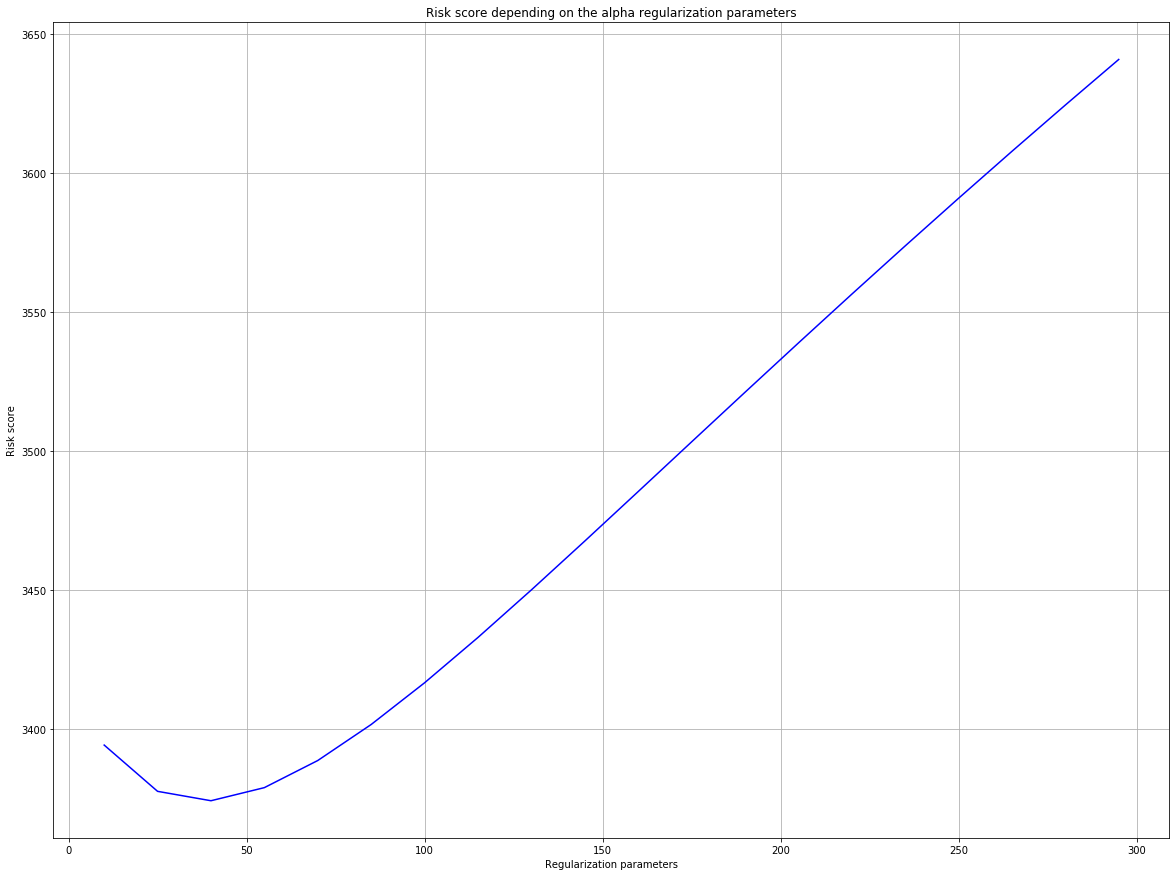

In [67]:
plt.figure(figsize=(20,15))
plt.title("Risk score depending on the alpha regularization parameters")
plt.xlabel("Regularization parameters")
plt.ylabel("Risk score")
plt.plot(alphas, risk_score_pred_Ridge ,'-', color='b')
plt.grid(True)
plt.show();

In [68]:
best_alpha = alphas[np.argmin(risk_score_pred_Ridge)]

best_model = Ridge(best_alpha, fit_intercept=False)
best_model.fit(X_train - np.mean(X_train), y_train - np.mean(y_train))

y_pred_ridge_best_model = best_model.predict(X_test - np.mean(X_test))
risk_score_ridge_best_model = mean_squared_error(y_pred_ridge_best_model, y_test - np.mean(y_test))

print("-------- Ridge --------")
print("Le risque de prédiction minimal est atteint pour alpha = {}".format(best_alpha))
print("Le risque de prédiction atteint pour ce paramètre est de {:.0f}".format(risk_score_ridge_best_model))

-------- Ridge --------
Le risque de prédiction minimal est atteint pour alpha = 40
Le risque de prédiction atteint pour ce paramètre est de 2991


La méthode **Ridge** nous retourne donc un **risque équivalent** à ceux de la méthode **Forward** et **OLS with PCA**.

---------------
### Question 13 :
>A l’aide de la fonction `lassoCV` de sklearn, choisir le paramètre de régularisation du LASSO.
Donner le risque de prédiction associé.

In [56]:
lasso_reg_cv = LassoCV(cv=3)
# On utilise des variables centrées
lasso_reg_cv.fit(X_train - np.mean(X_train), y_train - np.mean(y_train))
alpha_lasso = lasso_reg_cv.alpha_

y_pred_lasso = lasso_reg_cv.predict(X_test - np.mean(X_test))
risk_score_lasso = mean_squared_error(y_test - np.mean(y_test), y_pred_lasso)
#R2_lasso = r2_score(y_test, lasso_reg_cv.predict(X_test))

print(f"Le paramètre optimal de régularisation pour le Lasso est alpha = {round(alpha_lasso,3)}")
print(f"Le risque de prédiction associé sur l'échantillon test est de {round(risk_score_lasso)}")

Le paramètre optimal de régularisation pour le Lasso est alpha = 7.116
Le risque de prédiction associé sur l'échantillon test est de 3245.0


Avec le modèle LASSO, nous obtenons une légèrement moins bonne minimisation du risque qu'avec Ridge.

---------------
### Question 14 : 
> * Donner les variables selectionées par le Lasso. Combien y-en a t-il ? 
* Appliquer la méthode OLS aux variables sélectionnées. Cette méthode est appelé Least-square LASSO.

In [57]:
lasso_coeff = pd.Series(lasso_reg_cv.coef_)
lasso_variables = lasso_coeff[lasso_coeff!=0].index

print(f"Les variables sélectionnées sont au nombre de {len(lasso_variables)} et sont les suivantes : ")
print (np.asarray(lasso_variables))

Les variables sélectionnées sont au nombre de 5 et sont les suivantes : 
[ 28  58 123 167 174]


In [58]:
print(lasso_coeff[lasso_coeff!=0])

28      0.128209
58     23.220379
123    19.753726
167     8.759549
174    -6.153717
dtype: float64


In [59]:
linear_reg_lasso = linear_model.LinearRegression()
linear_reg_lasso.fit(X_train.iloc[:,lasso_reg_cv.coef_ != 0], y_train)

y_predict_lasso = linear_reg_lasso.predict(X_test.iloc[:,lasso_reg_cv.coef_ != 0])

risk_score_LeastSquare_lasso = mean_squared_error(y_test, y_predict_lasso)
#R2_LeastSquare_lasso = r2_score(y_test_lasso, y_predict_lasso)

print(f"Le risque de prédiction pour la méthode Least-square Lasso est de : {round(risk_score_LeastSquare_lasso)}")

Le risque de prédiction pour la méthode Least-square Lasso est de : 3265.0


---------------
### Question 15 : 
>Cette dernière question est un question d’ouverture vers une approche non-linéaire. En
utilisant les variables séléctionées par le LASSO (Q13) ou par la méthode forward (Q9),
mettre au point une méthode de regression non-linéaire. On apprendra les différents paramètres par validation croisée et l’on donnera la valeur du risque de prédiction calculé
sur l’échantillon test. Des performances moindres par rapport à OLS peuvent se produire.
Commenter.

Il peut être intéressant ici de tester des modèles non linéaires tels que le `GradientBoostingRegressor`, l'`AdaBoostRegressor` ou encore le `RandomForestRegressor`. Nous choisissons toutefois de tester les modèles de `DecisionTreeRegressor` et le `RandomForestRegressor`. La sélection des hyperparamètres optimaux se fera à l'aide de la fonction `GridSearchCV` qui utilise une cross-validation pour sélectionner le modèle optimal.

Commençons donc avec `DecisionTreeRegressor`.

In [60]:
decision_tree_regressor = DecisionTreeRegressor(random_state=0)
decision_tree_regressor.fit(X_train.iloc[:,lasso_reg_cv.coef_ != 0], y_train)

y_predict_decision_tree_regressor = decision_tree_regressor.predict(X_test.iloc[:,lasso_reg_cv.coef_ != 0])

parameters = {'max_depth':range(1,20)}

classifier = GridSearchCV(tree.DecisionTreeRegressor(), parameters, n_jobs=4)
classifier.fit(X_train.iloc[:,lasso_reg_cv.coef_ != 0], y_train)

risk_score_decision_tree_regressor = mean_squared_error(y_test, y_predict_decision_tree_regressor)
decision_tree_param = classifier.best_params_
#R2_decision_tree_mean = classifier.best_score_

print (f"Le paramètre optimal trouvé par cross validation est {decision_tree_param}")
print(f"Le risque de prédiction du modèle non linéaire DecisionTree est de {round(risk_score_decision_tree_regressor)}")
#print(f"Le coefficient de détermination moyen associé est de {round(R2_decision_tree_mean,4)} ")

Le paramètre optimal trouvé par cross validation est {'max_depth': 2}
Le risque de prédiction du modèle non linéaire DecisionTree est de 6724.0


Les risque de prédiciton étant très grand en comparaison des autres modèles utilisés, **nous ne retiendrons pas le modèle de** `DecisionTreeRegressor`.

Voyons si nous pouvons faire mieux avec le `RandomForestRegressor`.

In [61]:
random_forest_regressor = RandomForestRegressor(max_depth=2, random_state=0)
random_forest_regressor.fit(X_train.iloc[:,lasso_reg_cv.coef_ != 0], y_train)

y_predict_random_forest_regressor = random_forest_regressor.predict(X_test.iloc[:,lasso_reg_cv.coef_ != 0])

risk_score_random_forest_regressor = mean_squared_error(y_test, y_predict_random_forest_regressor)


classifier2 = GridSearchCV(RandomForestRegressor(), parameters, n_jobs=4)
classifier2.fit(X_train.iloc[:,lasso_reg_cv.coef_ != 0], y_train)

#tree_model = classifier2.best_estimator_
#tree_model.fit(X_train_lasso, y_train_lasso)

risk_score_random_forest_regressor = mean_squared_error(y_test, y_predict_random_forest_regressor)
random_forest_param = classifier2.best_params_
#R2_random_forest_mean = classifier.best_score_
#R2_random_forest = r2_score(y_test, y_predict_random_forest_regressor)


print (f"Le paramètre optimal trouvé par cross validation est {random_forest_param}")
#print(f"Le coefficient de détermination moyen associé est de {round(R2_random_forest_mean,4)} ")
#print(f"Le coefficient de détermination sur l'échantillon de test est de {round(R2_random_forest,4)}")
print(f"Le risque de prédiction du modèle non linéaire Random Forest est de {round(risk_score_random_forest_regressor)}")


Le paramètre optimal trouvé par cross validation est {'max_depth': 3}
Le risque de prédiction du modèle non linéaire Random Forest est de 3286.0


Le risque de prédiciton est raisonnable comparé aux autres méthodes linéaires mais nous n'avons pas amélioré le modèle.